# Importing the libraries

In [1]:
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D,ReLU
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# GPU Check

In [ ]:
num_gpu_available = len(tf.config.list_physical_devices('GPU'))
if num_gpu_available == 0 :
  print("You are not using GPU\n")
else:
  print("You are using GPU\n")

You are not using GPU



# Loading Dataset

## Loading the dataset from the csv file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Loading icml_face_data.csv into dataframe df_icml
df_icml = pd.read_csv("/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv",sep=",")

# Columns renamed for easier access.
df_icml.rename(columns = {' Usage':'usage'}, inplace = True)
df_icml.rename(columns = {' pixels':'pixels'}, inplace = True)

# Transforming pixel strings into 48x48 tensors of float32
df_icml["pixels"] = df_icml['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48,1).astype('float32'))

# Creating the df_train,df_val_df_test dataframes
df_train = df_icml.loc[df_icml['usage'].isin(["Training"])]
df_val = df_icml.loc[df_icml['usage'].isin(["PrivateTest"])]
df_test = df_icml.loc[df_icml['usage'].isin(["PublicTest"])]


Mounted at /content/drive


## Creating the Train,Val,Test split

In [3]:



# Creating the train,val,test split accordingly to the specifics of the poject.

le = LabelEncoder()                                                               # declaration of the label encoder to later transform the labels

# Train 
X_train = df_train['pixels']
X_train = np.stack(X_train, axis=0)
print("X_train has shape: ")
print(X_train.shape)
y_train = df_train["emotion"].to_numpy()
y_train = to_categorical(y_train)
print("y_train has shape: ")
print(y_train.shape)

# Validation
X_val = df_val['pixels']
X_val = np.stack(X_val, axis=0)
print("X_val has shape: ")
print(X_val.shape)
y_val = df_val["emotion"].to_numpy()
y_val = to_categorical(y_val)
print("y_val has shape: ")
print(y_val.shape)

# Test
X_test = df_test['pixels']
X_test = np.stack(X_test, axis=0)
print("X_test has shape: ")
print(X_test.shape)
y_test = df_test["emotion"].to_numpy()                                           # transforming the y_test series into numpy array
y_test = to_categorical(y_test)
print("y_test has shape: ")
print(y_test.shape)




X_train has shape: 
(28709, 48, 48, 1)
y_train has shape: 
(28709, 7)
X_val has shape: 
(3589, 48, 48, 1)
y_val has shape: 
(3589, 7)
X_test has shape: 
(3589, 48, 48, 1)
y_test has shape: 
(3589, 7)


# Loading the model 
In questa sezione il modello allenato precedentemente viene caricato nella sua completezza.
Una volta caricato il modello si va direttamente alla fase di testing.

In [4]:
model = keras.models.load_model("/content/drive/MyDrive/saved_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 48, 48, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_8 (ReLU)              (None, 48, 48, 64)       

# Building the Five-Layers-CNN from scratch

## Creazione del modello
Qui il modello viene creato da zero.


In [8]:
model = Sequential()

# First Layer : Input

# Second Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),input_shape = (48, 48, 1),padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model.add(Dropout(0.4))
#-------------------------------------------------------------------------------------------------------------------------------#

# Third Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model.add(Dropout(0.4))
#-------------------------------------------------------------------------------------------------------------------------------#

# Fourth Layer
model.add(Conv2D(filters = 512,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Flatten(name='flatten'))       
model.add(Dense(512,kernel_initializer='he_normal',))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.6))
model.add(Dense(7,activation='softmax'))


# Dopo che il modello è stato creato,lo visualizziamo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 48, 48, 64)        0

## Compilazione del modello
Qui viene compilato il modello,in particolare vengono definite:


*   la funzione di loss (categorical crossentropy)
*   l'ottimizzatore (adam optimizer)
*   le metriche (accuracy)







In [9]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [10]:
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=0.00001,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
gen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True
)
gen.fit(X_train)

In [12]:
X_train.shape

(28709, 48, 48, 1)

# Training the Five-Layers-CNN

In [14]:
print("Allenamento della rete\n")
history = model.fit(X_train,y_train,batch_size=8,epochs=10,callbacks = callbacks,validation_data=(X_val, y_val))


Allenamento della rete

Epoch 1/5
2871/2871 [==============================] - 54s 19ms/step - loss: 1.3181 - accuracy: 0.4954 - val_loss: 1.2016 - val_accuracy: 0.5364 - lr: 0.0010
Epoch 2/5
2871/2871 [==============================] - 54s 19ms/step - loss: 1.2396 - accuracy: 0.5289 - val_loss: 1.0970 - val_accuracy: 0.5887 - lr: 0.0010
Epoch 3/5
2871/2871 [==============================] - 54s 19ms/step - loss: 1.1752 - accuracy: 0.5576 - val_loss: 1.0986 - val_accuracy: 0.5823 - lr: 0.0010
Epoch 4/5
2871/2871 [==============================] - 53s 19ms/step - loss: 1.1137 - accuracy: 0.5794 - val_loss: 1.0372 - val_accuracy: 0.6124 - lr: 0.0010
Epoch 5/5
2871/2871 [==============================] - 53s 19ms/step - loss: 1.0559 - accuracy: 0.6051 - val_loss: 1.0253 - val_accuracy: 0.6116 - lr: 0.0010


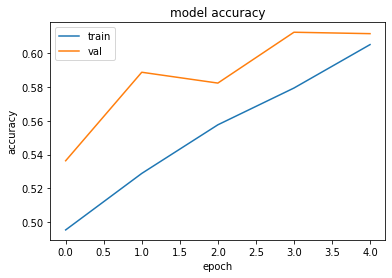

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing the Five-Layers-CNN

## Test sull'intero test set


In [5]:
res = model.evaluate(X_test,y_test,batch_size = 8)
print("Loss : %f , Accuracy : %f" %(res[0],res[1]))

449/449 [==============================] - 9s 5ms/step - loss: 1.0155 - accuracy: 0.6400
Loss : 1.015466 , Accuracy : 0.640011


## Test su batch di dimensione arbitraria


In [ ]:
# Definizione della funzione che crea un batch lungo n di samples dal set passato
def random_images(X,n):
  X_len = X.shape[0]
  ran_indices = random.sample(range(0,X_len,1),n)
  list = []
  for i in range(0,n):
    list.append(X[ran_indices[i]])

  return tf.stack(list),ran_indices

In [ ]:
n = int(input("Inserisci qui il numero di sample su cui fare testing.\n"))

Inserisci qui il numero di sample su cui fare testing.
100


4/4 [==============================] - 2s 402ms/step
Groundtruth:



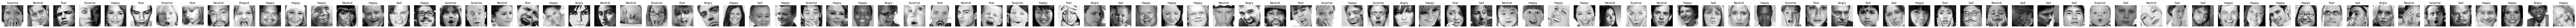



Predictions:



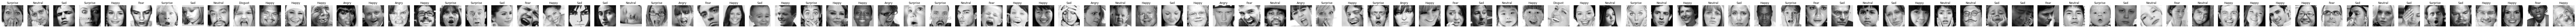

In [ ]:
# Verifica dell'output della rete appena allenata su un campione casuale di 10 immagini dal test set
emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
images,indexes = random_images(X_test,n)
predictions = model.predict(images)

# Visualizzazione delle immagini con le loro labels corrette
fig1 = plt.figure(figsize=(2*n, 2*n))
print("Groundtruth:\n")
j=1
for i in range(0,n):
  fig1.add_subplot(1,n,j)
  plt.axis("off")
  plt.imshow(images[i].numpy().reshape(48,48),cmap="gray")
  plt.title(emotions[y_test[indexes[i]].argmax()])
  j = j+1
plt.show(fig1)
print("\n")
# Visualizzazione delle immagini con le labels predette dalla rete
fig2 = plt.figure(figsize=(2*n, 2*n))
print("Predictions:\n")
j=1
for i in range(0,n):
  fig2.add_subplot(1,n,j)
  plt.axis("off")
  plt.imshow(images[i].numpy().reshape(48,48),cmap="gray")
  plt.title(emotions[predictions[i].argmax()])
  j = j+1
plt.show(fig2)

# Saving the model
Dopo aver allenato il modello,quest ultimo viene salvato,per poter essere caricato in futuro.

In [ ]:
model.save(filepath="/content/drive/MyDrive/saved_model.h5",save_format="h5")